In [53]:
from __future__ import division, print_function

import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import pandas as pd
import datetime
import glob

import matplotlib.lines as mlines
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.basemap import Basemap

%matplotlib inline

25
['\x88', '\x17', '\xd9', 'Q', '\xb9', '\x7f', '', '', '', '.', ',']
2003
0
/home/mgrenier/Documents/Data_Arctic/CTDBeaufortGyreWHOI/LSSL_ctd2003/1db_down
47
47
(47,)
(47, 5000)
2004
50
50
(50,)
(50, 5000)
2005
0
/home/mgrenier/Documents/Data_Arctic/CTDBeaufortGyreWHOI/LSSL_ctd2005/1db_down
50
50
(50,)
(50, 5000)
2006
0
/home/mgrenier/Documents/Data_Arctic/CTDBeaufortGyreWHOI/LSSL_ctd2006/1db_down
64
64
(64,)
(64, 5000)
2007
0
/home/mgrenier/Documents/Data_Arctic/CTDBeaufortGyreWHOI/LSSL_ctd2007/1db_down
106
106
(106,)
(106, 5000)
2008
146
146
(146,)
(146, 5000)
2009
53
53
(53,)
(53, 5000)
2010
72
72
(72,)
(72, 5000)
2011
52
52
(52,)
(52, 5000)
2012
56
56
(56,)
(56, 5000)
2013
55
55
(55,)
(55, 5000)


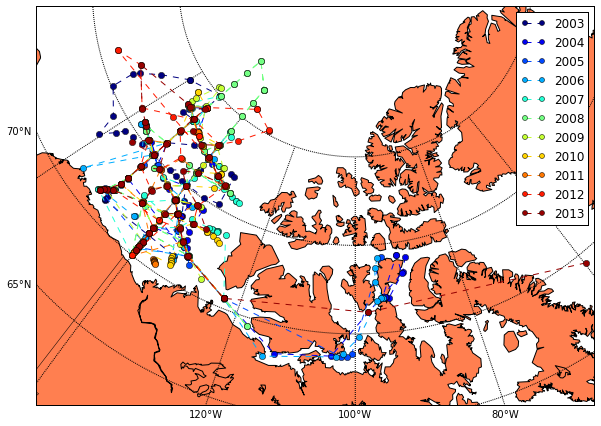

In [55]:
### Draw the map for the location of the stations

#m = Basemap(llcrnrlon=-170, llcrnrlat=65, urcrnrlon=-50, urcrnrlat=85,lon_0=-100, resolution='l',area_thresh=10,projection='merc')
fig,ax=plt.subplots(1,1,facecolor='w',figsize=(10,10))
x=100000
m = Basemap(llcrnrx=-20*x, llcrnry=-10*x, urcrnrx=+15*x, urcrnry=+15*x,lon_0=-100, lat_0=75,projection='ortho',resolution='l')
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='coral')

m.drawmeridians(np.arange(-160,-50,20), labels=[0,0,0,1])
m.drawparallels(np.arange(65,85,5), labels=[1,0,0,0])

cmap = plt.get_cmap('jet')


### Read the CNV files and extract the variables of interest

#DIRECTORY = globals()['/home/mgrenier/Documents/Data_Arctic/CTDBeaufortGyreWHOI/LSSL_ctd' % i] 
DIRECTORY0 = '/home/mgrenier/Documents/Data_Arctic/CTDBeaufortGyreWHOI/'
DIRECTORY = [DIRECTORY for DIRECTORY in os.listdir(DIRECTORY0) if DIRECTORY.startswith('LSSL')]
DIRECTORY.sort()
#print(DIRECTORY0,DIRECTORY[0])
    ### Range of years over which data were collected
i_init=2003
i_final=2013
coef=int(255/(i_final-i_init))
print(coef)

legend=list(np.chararray((i_final-i_init+1)))

press=list(np.chararray((i_final-i_init+1)))
temp=list(np.chararray((i_final-i_init+1)))
sal=list(np.chararray((i_final-i_init+1)))
potemp=list(np.chararray((i_final-i_init+1)))
dens=list(np.chararray((i_final-i_init+1)))

DIR=list(np.chararray((i_final-i_init+1)))

print(legend)

for i in xrange(i_init,i_final+1,1):
    globals()['l%s' %i]='a'
    legend[i-i_init]=globals()['l%s' %i]

    press[i-i_init]='press'+str(i)
    temp[i-i_init]='temp'+str(i)
    sal[i-i_init]='sal'+str(i)
    dens[i-i_init]='dens'+str(i)
    potemp[i-i_init]='potemp'+str(i)
    
    DIR[i-i_init]='DIR'+str(i)

#print(legend)

   
for i in xrange(i_init,i_final+1,1):
    ind=0
    print(i)
    DIR[i-i_init] = os.path.join(DIRECTORY0,DIRECTORY[i-i_init])

    QUANTITIES = {
        'prDM': press[i-i_init], # pressure
        't090C': temp[i-i_init], # temperature
        'sal00': sal[i-i_init], # salinity
        'potemp090C': potemp[i-i_init], # potential temperature
        'sigma-é00': dens[i-i_init], # sigma theta
    }
    
    QUANTITIES2 = {
        'Pressure,': press[i-i_init], # pressure
        'Temperature,': temp[i-i_init], # temperature
        'Salinity,': sal[i-i_init], # salinity
    }


    filenames = [f for f in os.listdir(DIR[i-i_init]) if (f.endswith('.cnv') or f.endswith('.ctd'))]
    filenames.sort()
    print(len(filenames))
    ### If files are in subdirectories (e.g.: 1db_down because 1db_up is also available)
    if len(filenames) == 0:
        DIRECTORY1 = [DIRECTORY1 for DIRECTORY1 in os.listdir(DIR[i-i_init]) if DIRECTORY1.endswith('down')]
        #print(globals()['DIRECTORY%s' %i],DIRECTORY1[0])
        DIR[i-i_init] = os.path.join(DIR[i-i_init],DIRECTORY1[0])
        print(DIR[i-i_init])
        filenames = [f for f in os.listdir(DIR[i-i_init]) if (f.endswith('.cnv') or f.endswith('.ctd'))]
        print(len(filenames))
    
    l=len(filenames)
    print(l)
    
    globals()['latitude%s' %i]=np.zeros(l)
    globals()['longitude%s' %i]=np.zeros(l)
    globals()['time%s' %i]=np.zeros(l)
    globals()['p%s' %i]=np.empty((l,5000))
    globals()['T%s' %i]=np.empty((l,5000))
    globals()['S%s' %i]=np.empty((l,5000))
    globals()['theta%s' %i]=np.empty((l,5000))
    globals()['dens%s' %i]=np.empty((l,5000))
    globals()['p%s' %i][:]=np.NAN    
    globals()['T%s' %i][:]=np.NAN
    globals()['S%s' %i][:]=np.NAN    
    globals()['theta%s' %i][:]=np.NAN
    globals()['dens%s' %i][:]=np.NAN
    print(globals()['latitude%s' %i].shape)
    print(globals()['S%s' %i].shape)

    for filename in sorted(filenames):
        f = open(os.path.join(DIR[i-i_init], filename), 'rt')
        j=-1
        ind=ind+1
        #print(f.shape[0][1][2)
        for line in f:
            line = line.strip()
            word = line.split()
            #print(line.split(',')[0])
            #print(word[0])
            #print(line[:])

            if (line.startswith('*') or word[0].startswith('L') or word[0].startswith('D')): #'*' for .cnv files; 'L' or 'D' 
#for .ctd files
                # header line, look for useful info
                if 'Latitude' in line:
                    #print(word[2])#,word[4],word[5])
                    if word[2] == 'Latitude':
                        globals()['latitude%s' %i][ind-1]= float(word[4])+ float(word[5])/60
                        #print(globals()['latitude%s' %i].shape)
                        #print(globals()['latitude%s' %i][0])
                    else:
                        globals()['latitude%s' %i][ind-1]= float(word[2])+ float(word[3])/60
                if 'LATITUDE' in line:
                    #print(word[2])
                    globals()['latitude%s' %i][ind-1]= float(word[2])
                if 'Longitude' in line:
                    #print(word[2],word[4],word[5])
                    if word[2] == 'Longitude':
                        globals()['longitude%s' %i][ind-1] = -(float(word[4])+ float(word[5])/60)                   
                    else:
                        globals()['longitude%s' %i][ind-1]= -float(word[2])+ float(word[3])/60
                if 'LONGITUDE' in line:
                    #print(word[2])
                    globals()['longitude%s' %i][ind-1]= -float(word[2])
                if '(Time)' in line:
                    #print(word[3])#,word[6],word[7],word[8])
                    if word[3] == '(Time)':
                        string = word[7] + ' ' + word[5] + ' ' + word[6] # Date only
                        #string = word[7] + ' ' + word[5] + ' ' + word[6] + ' ' + word[8] # Date & time
                        #print(string)
                        globals()['time%s' %i] = datetime.datetime.strptime(str(string),'%Y %b %d') # Date only
                        #globals()['time%s' %i] = datetime.datetime.strptime(str(string),'%Y %b %d %H:%M:%S') # Date & time
                        #print(globals()['time%s' %i])
                    else:
                        string = word[5] + ' ' + word[3] + ' ' + word[4]
                        globals()['time%s' %i] = datetime.datetime.strptime(str(string),'%Y %b %d') # Date only
                if 'DATE' in line:
                    #print(word[2])
                    string = word[2]
                    globals()['time%s' %i] = datetime.datetime.strptime(str(string),'%d-%b-%Y')
                    globals()['time%s' %i].strftime('%Y %b %d')
                if '** Station' in line:
                    station = line.partition(': ')[2]
                #if line == '*END*':
                 #   break
            elif line.startswith('# name'):     
                # comment line, look for plotable quantities information
                #print(QUANTITIES.items())
                #print(line.partition(': ')[2])
                #print(int(line.split(' ')[2]))
                if 'prDM' in line:
                    indexp = int(line.split(' ')[2])
                if 't090C' in line:
                    indexT = int(line.split(' ')[2])
                if 'sal00' in line:
                    indexS = int(line.split(' ')[2])
                if 'potemp090C' in line:
                    indexTheta = int(line.split(' ')[2])
                if 'sigma-é00' in line:
                    indexSig = int(line.split(' ')[2])
                    #print(indexS)
                
                
            elif (line.startswith('1') or line.startswith('2') or line.startswith('3') 
                  or line.startswith('4') or line.startswith('5') or line.startswith('6') or 
                  line.startswith('7') or line.startswith('8') or line.startswith('9')) and ',' in line: ### ctd files 
                    j=j+1
                    #print(line.split(',')[2])
                    globals()['p%s' %i][ind-1,j]= line.split(',')[0]
                    globals()['T%s' %i][ind-1,j]= line.split(',')[1]
                    globals()['S%s' %i][ind-1,j]= line.split(',')[2]

            elif (line.startswith('1') or line.startswith('2') or line.startswith('3') 
                  or line.startswith('4') or line.startswith('5') or line.startswith('6') or 
                  line.startswith('7') or line.startswith('8') or line.startswith('9')) and ',' not in line: ### CNV files
                    j=j+1                    
                    globals()['p%s' %i][ind-1,j]= word[indexp]
                    globals()['T%s' %i][ind-1,j]= word[indexT]
                    globals()['S%s' %i][ind-1,j]= word[indexS]
                    if float(word[indexSig]) < 15.0: ### mistake in files from 2004: inversion of density column and pot temp column 
                        #print("Inversion Theta/Sig!!!")
                        globals()['theta%s' %i][ind-1,j]= word[indexSig]
                        globals()['dens%s' %i][ind-1,j]= word[indexTheta]
                    else:
                        globals()['theta%s' %i][ind-1,j]= word[indexTheta]
                        globals()['dens%s' %i][ind-1,j]= word[indexSig]    
                    #print(globals()['dens%s' %i][ind-1,j])
                    
    #print(globals()['longitude%s' %i][2],globals()['time%s' %i])
    #print(globals()['S%s' %i][0,:],globals()['S%s' %i][1,:])
    #print(globals()['S%s' %i][0,:],globals()['S%s' %i][1,:])

    xs,ys= m(globals()['longitude%s' %i],globals()['latitude%s' %i])
    plt.plot(xs,ys,'o--',color=cmap((i-2003)*coef),label=i)
    globals()['l%s' % i] = mlines.Line2D([], [],linestyle='--',marker='o',color=cmap((i-2003)*coef),markersize=5, label=i)
    legend[i-i_init]=globals()['l%s' % i]
    #print(legend)
lgd=plt.legend(handles=legend,loc=1)
frame = lgd.get_frame()
frame.set_facecolor('1.0')

plt.show()


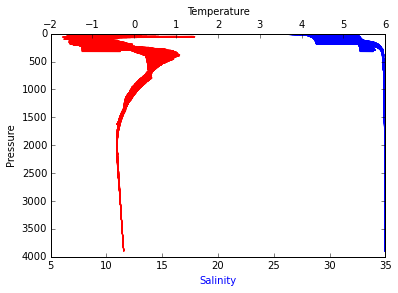

In [60]:
#for i in xrange(i_init,i_final,1)    
ax1 = plt.axes()#[0.08,0.1,0.25,0.4])
ax1.invert_yaxis()

ax1.plot(S2004,p2004,'b')    
ax1.set_xlabel('Salinity')
ax1.xaxis.label.set_color('blue')
ax1.set_ylabel('Pressure')
ax2 = ax1.twiny()
ax2.plot(T2004,p2004,'r')
ax2.set_xlabel('Temperature')
    
plt.show()

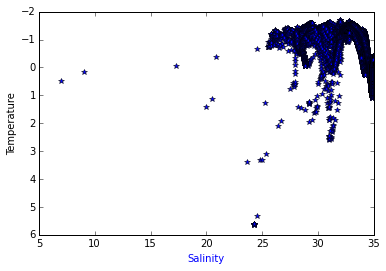

In [61]:
    ax1 = plt.axes()
    ax1.invert_yaxis()

    ax1.plot(S2004,T2004,'b*')    
    ax1.set_xlabel('Salinity')
    ax1.xaxis.label.set_color('blue')
    ax1.set_ylabel('Temperature')
    
plt.show()